# Python and Sionna RT Environment Config

In [17]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import sionna
from sionna.rt import load_scene
# from sionna import load_scene
from matplotlib.colors import ListedColormap
import importlib
import SceneConfigSionna2  
import runSimu 
import BeamformingCalc2
importlib.reload(SceneConfigSionna2) 
importlib.reload(runSimu) 
importlib.reload(BeamformingCalc2) 
from SceneConfigSionna2 import SceneConfigSionna
from runSimu import run_simulations
from BeamformingCalc2 import svd_bf, nulling_bf
import random

✅ Using GPU: /physical_device:GPU:0


In [18]:
# scenegen bbox -105.097 40.0371 -105.06 40.0697 --data-dir scenes/Denver
# scene = load_scene("../Denver/denver.xml")
scene = load_scene("../blouder_plane_itu3/boulder_plane_itu.xml")
# scene = load_scene("../Denver_Scene/Boulder2_2/Boulder2.xml")

Parmeters

In [23]:
nbs = 1
nsect = 3
ntn_rx=300
tn_rx=200
bs_dist_min=35
bs_dist_max=3000

tx_antenna_rows = 4
tx_antenna_cols = 16
tn_rx_antenna_rows = 1
tn_rx_antenna_cols = 1
tx_antennas = tx_antenna_rows*tx_antenna_cols
tn_antennas = tn_rx_antenna_rows*tn_rx_antenna_cols



EkT = -174    # Noise energy in dBm/Hz, antenna temperature for vsat: 290K
B = 100e6
Tx_power_dbm = 30 # dbm
Tx_power = 10 ** ((Tx_power_dbm - 30) / 10)

NF = 7  # Noise figure in dB
NF_vsat = 3
NF_bs = 2
# reference signal duration
N0_dBm = EkT + 10 * np.log10(B) + NF
N0 = 10 ** ((N0_dBm - 30) / 10)
N0_vsat =  10 ** ((EkT + 10 * np.log10(B) + NF_vsat - 30) / 10)
N0_bs =  10 ** ((EkT + 10 * np.log10(B) +NF_bs - 30) / 10)

# For channel estimation interference distribution, h_hat = h + CN~(0, N0/(Tx_power*time))
time = 20e-6 
N0_sigma = N0_vsat /Tx_power/time 



signal_detection_th = -10
snr_threshold = -6  # SNR threshold in dB
inr_threshold = -6
h_ntn_th = np.sqrt(10**(inr_threshold/10)*N0_bs*tx_antennas /Tx_power)
h_tn_th = np.sqrt(10**(snr_threshold/10)*N0_bs*tx_antennas /Tx_power)
n_sim = 1
azimuth = np.random.uniform(0, 360)
elevation = np.random.uniform(25, 90)


Run Simu

In [24]:
interference_ntn = 0   
Used_tn = 0   
total_ntn = 0

inr_list = []
ntn_kept_indices = []
mask_record = []  # To store all mask arrays
snr_list = []
Q_1_dB_list = []
h_ntn_dB_list = []
h_tn_dB_list = []
lambda_ranges = [1e10,1e11,1e12] 
eigen_value_dict = {l: [] for l in lambda_ranges}
snr_nulling_dict = {l: [] for l in lambda_ranges}
snr_nulling_hat_dict = {l: [] for l in lambda_ranges}
snr_degration_dict = {l: [] for l in lambda_ranges}
inr_nulling_dict = {l: [] for l in lambda_ranges}
inr_nulling_hat_dict = {l: [] for l in lambda_ranges}


w_t_record = []  # List of w_t vectors
v_null_record = {l: [] for l in lambda_ranges} 
   
for sim in tqdm(range(n_sim), desc="Simulations"):     
    
    SceneConfig = SceneConfigSionna(scene, nbs = nbs, nsect = nsect, fc =9.99e9)
    SceneConfig.compute_positions(ntn_rx=ntn_rx, tn_rx=tn_rx,  azimuth=azimuth, elevation =elevation,
                                    centerBS=True, bs_dist_min=bs_dist_min, bs_dist_max=bs_dist_max)
    SceneConfig.compute_paths(tx_rows = tx_antenna_rows, tx_cols = tx_antenna_cols, tn_rx_rows = tn_rx_antenna_rows, 
                            tn_rx_cols = tn_rx_antenna_cols, max_depth=3)
    det_ntn_max = 0
    a_ntn = SceneConfig.a_ntn
    a_tn = SceneConfig.a_tn
    bs_tn_pos = SceneConfig.bs_tn_pos
    tx_pos = SceneConfig.tx_pos
    rx_ntn_pos = SceneConfig.rx_ntn_pos

    h_tn_all = np.sum(SceneConfig.a_tn, axis = 4).squeeze()
    if h_tn_all.ndim == 3:
        h_tn_all = h_tn_all.reshape(h_tn_all.shape[0], 1, h_tn_all.shape[1], h_tn_all.shape[2])
    h_ntn_all = np.sum(SceneConfig.a_ntn, axis = 4).squeeze()
    if h_ntn_all.ndim == 2:
        h_ntn_all = h_ntn_all.reshape(1, h_ntn_all.shape[0], h_ntn_all.shape[1])
        
    interference_ntn += np.count_nonzero(np.any(h_ntn_all != 0, axis=(1, 2)))

    best_tx_list = []  # Stores the best t for each r
    bs_tx_tn = []  # Stores the corresponding bs_tn_pos
    w_t_grouped, w_r_grouped, h_grouped = {}, {}, {}
        
    for r in range(bs_tn_pos.shape[0]):  # Iterate over all tx antennas
        max_snr = -np.inf  # Initialize max SNR for each r
        best_tx = None  # Store the best t for the current r
        best_w_t = None  # Store the best w_t
        best_w_r = None  # Store the best w_r
        best_h_tn = None

        for t in range(nbs * nsect):  # Iterate over all tn-users
            h_tn = h_tn_all[r, :, t, :].T  
            h_tn_norm = np.linalg.norm(h_tn, ord='fro')      
            h_tn_dB = 10 * np.log10(h_tn_norm**2)
            h_tn_dB_list.append(h_tn_dB.item())

            if np.any(h_tn_norm > h_tn_th):  # Consider significant channels only
                # h_tn_dB = 10 * np.log10(h_tn_norm**2)
                # h_tn_dB_list.append(h_tn_dB.item())
                w_t, w_r = svd_bf(h_tn,tx_antennas)
                # Compute SNR
                snr = 10 * np.log10((np.abs(w_t.conj().T @ h_tn @ w_r)**2) * Tx_power / N0)
                # if random.random() < 0.5:  
                #     snr -= 20

                # Update the maximum SNR for the current tn_rx
                if snr > max_snr:   # Consider significant channels only
                    max_snr = snr
                    best_tx = t     # Store the best tx
                    best_w_t = w_t  # Store the best w_t
                    best_w_r = w_r  # Store the best w_r
                    best_h_tn = h_tn

        # Only add if max SNR is above the threshold
        if best_tx is not None:
            best_tx_list.append(best_tx)  # Store best t for this r
            snr_list.append(max_snr.item())  # Store SNR value
            bs_tx_tn.append(bs_tn_pos[r, :])  # Append the corresponding bs_tn_pos row
            # Store directly in grouped dictionaries
            if best_tx not in w_t_grouped:
                w_t_grouped[best_tx], w_r_grouped[best_tx], h_grouped[best_tx] = [], [], []

            w_t_grouped[best_tx].append(best_w_t)
            w_r_grouped[best_tx].append(best_w_r)
            h_grouped[best_tx].append(best_h_tn)

    # Convert lists to NumPy arrays for consistency
    bs_tx_tn = np.array(bs_tx_tn) if bs_tx_tn else np.empty((0, bs_tn_pos.shape[1]))
    best_tx_list = np.array(best_tx_list)


    # Convert lists to NumPy arrays for consistency
    for best_tx in w_t_grouped:
        w_t_grouped[best_tx] = np.array(w_t_grouped[best_tx])
        w_r_grouped[best_tx] = np.array(w_r_grouped[best_tx])
        h_grouped[best_tx] = np.array(h_grouped[best_tx])

    _, counts = np.unique(best_tx_list, return_counts=True)
    min_count = np.min(counts)
    Used_tn += min_count


    for m in range(min_count):        
            
        h_i_gain_sum = np.zeros((ntn_rx,), dtype=np.float64)
        h_i_null_gain_sum_dict = {l: np.zeros((ntn_rx,), dtype=np.float64) for l in lambda_ranges}
        h_i_null_gain_sum_hat_dict = {l: np.zeros((ntn_rx,), dtype=np.float64) for l in lambda_ranges}
        
        for t in range(nbs * nsect):
            w_t = w_t_grouped[t][m]
            w_r = w_r_grouped[t][m]
            h = h_grouped[t][m]
            
            lhs = w_t.conj().T @ h  
            denominator = h.conj().T @ h  
            # v_t = h * (lhs / denominator)
            v_t = np.conj(w_t)
            w_t_record.append(v_t.copy())
            
            
            det_ntn = 0
        
            h_i = h_ntn_all[:, t, :]
            h_i_norms = np.linalg.norm(h_i, axis=1)
            h_ntn_dB = 10 * np.log10(h_i_norms ** 2)
            h_ntn_dB_list.append(h_ntn_dB)

            mask = h_i_norms <= h_ntn_th
            mask_record.append(mask.copy())
            indices_kept = np.where(~mask)[0]  # Get indices where mask == False
            ntn_kept_indices.append(indices_kept)
            noise = N0_sigma / np.sqrt(2) * (np.random.randn(*h_i.shape) + 1j * np.random.randn(*h_i.shape))
            h_i_hat = h_i + noise
            h_i[mask] = 0
            h_i_hat[mask] = 0
            
            det_ntn = np.count_nonzero(np.any(h_i != 0, axis=(1)))
            if det_ntn> det_ntn_max:
                det_ntn_max = det_ntn
            

            h_i = h_i.reshape(np.size(h_i, axis=0), -1, 1)  # Reshape to (ntn_rx, tx_antennas, 1)
            interference_term = np.matmul(h_i, h_i.conj().transpose(0, 2, 1))  
            interference_term = np.sum(interference_term, axis=0)   # Sum over all ntn-users
            
            h_i_hat = h_i_hat.reshape(np.size(h_i, axis=0), -1, 1)  # Reshape to (ntn_rx, tx_antennas, 1)
            interference_term_hat = np.matmul(h_i_hat, h_i_hat.conj().transpose(0, 2, 1))  
            interference_term_hat = np.sum(interference_term_hat, axis=0)   # Sum over all ntn-users
            
            h_i_gain = (np.abs(np.matmul(w_t.conj().T, h_i)) ** 2).squeeze()  # Shape: (ntn_rx)
            h_i_gain_sum += h_i_gain  # Element-wise sum over all t

            for lambda_ in lambda_ranges:  
            
                v_null, Q_1, Q_2,max_eigen_value = nulling_bf(h, w_r, interference_term, lambda_,tx_antennas)
                v_null_hat,_,_,_ = nulling_bf(h, w_r, interference_term_hat, lambda_,tx_antennas)
                
                
                lhs2 = v_null.conj().T @ h  
                denominator2 = h.conj().T @ h  
                # v_null_t = h * (lhs2 / denominator2)
                v_null_t = np.conj(v_null)
                v_null_record[lambda_].append(v_null_t.copy())
                
                eigen_value_dict[lambda_].append(max_eigen_value.item())

                snr_nulling = 10 * np.log10((np.abs(v_null.conj().T @ h @ w_r) ** 2) * Tx_power / N0)         
                snr_nulling_hat = 10 * np.log10((np.abs(v_null_hat.conj().T @ h @ w_r) ** 2) * Tx_power / N0)
                
                snr_nulling_dict[lambda_].append(snr_nulling.item())
                snr_nulling_hat_dict[lambda_].append(snr_nulling_hat.item())
                
                snr_degration = 10 * np.log10((np.abs(w_t.conj().T @ h @ w_r) ** 2)/(np.abs(v_null_hat.conj().T @ h @ w_r) ** 2) )
                snr_degration_dict[lambda_].append(snr_degration.item())

                # Compute nulling interference gain
                h_i_null_gain = (np.abs(np.matmul(v_null.conj().T, h_i)) ** 2).squeeze()
                h_i_null_gain_sum_dict[lambda_] += h_i_null_gain

                h_i_null_gain_hat = (np.abs(np.matmul(v_null_hat.conj().T, h_i)) ** 2).squeeze()
                h_i_null_gain_sum_hat_dict[lambda_] += h_i_null_gain_hat
                
        inr = 10 * np.log10(h_i_gain_sum*Tx_power/N0)
        inr_list.extend(inr)  # Append all elements to a flat list
        
        for lambda_ in lambda_ranges:
            inr_nulling = 10 * np.log10(h_i_null_gain_sum_dict[lambda_] * Tx_power / N0)
            inr_nulling_dict[lambda_].extend(inr_nulling)

            inr_nulling_hat = 10 * np.log10(h_i_null_gain_sum_hat_dict[lambda_] * Tx_power / N0)
            inr_nulling_hat_dict[lambda_].extend(inr_nulling_hat)
            
    total_ntn += det_ntn_max
            
print("interfered_ntn_number:", interference_ntn/n_sim)
print("Used_tn:", Used_tn/n_sim)
print("total_ntn:", total_ntn/n_sim)
unique_ntn_kept_indices = np.unique(np.concatenate(ntn_kept_indices))
left_ntn_pos = rx_ntn_pos[unique_ntn_kept_indices]
unique_ntn_kept_indices.shape

Simulations:   0%|          | 0/1 [00:00<?, ?it/s]/tmp/ipykernel_370396/723515070.py:132: RuntimeWarning: divide by zero encountered in log10
  h_ntn_dB = 10 * np.log10(h_i_norms ** 2)
/tmp/ipykernel_370396/723515070.py:190: RuntimeWarning: divide by zero encountered in log10
  inr = 10 * np.log10(h_i_gain_sum*Tx_power/N0)
/tmp/ipykernel_370396/723515070.py:194: RuntimeWarning: divide by zero encountered in log10
  inr_nulling = 10 * np.log10(h_i_null_gain_sum_dict[lambda_] * Tx_power / N0)
/tmp/ipykernel_370396/723515070.py:197: RuntimeWarning: divide by zero encountered in log10
  inr_nulling_hat = 10 * np.log10(h_i_null_gain_sum_hat_dict[lambda_] * Tx_power / N0)
Simulations: 100%|██████████| 1/1 [00:02<00:00,  2.41s/it]

interfered_ntn_number: 226.0
Used_tn: 1.0
total_ntn: 61.0


(140,)

In [32]:
v_t.shape

(64, 1)

In [25]:
np.save('left_ntn_pos8.npy', left_ntn_pos)

In [26]:
for i, arr in enumerate(ntn_kept_indices):
    print(f"第 {i} 个 array 的长度是: {len(arr)}")


第 0 个 array 的长度是: 61
第 1 个 array 的长度是: 24
第 2 个 array 的长度是: 56


In [27]:
# filtered_1 = bs_tx_tn[(bs_tx_tn[:, 0] > 500) & (bs_tx_tn[:, 0] < 1500)&(bs_tx_tn[:, 1] > -1500)&(bs_tx_tn[:, 1] < 1500)]
# print(filtered_1)

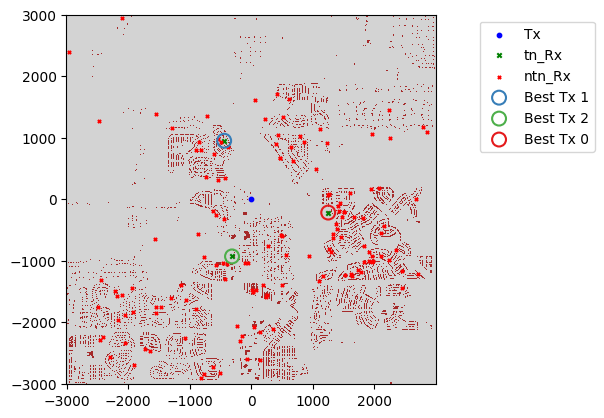

In [28]:
colors = ['lightgray', 'brown']
cmap = ListedColormap(colors)

extent = SceneConfig.extent
point_type = SceneConfig.point_type
plt.imshow(point_type, cmap=cmap, interpolation='nearest', extent=extent)
plt.scatter(tx_pos[:, 0], tx_pos[:, 1], color='blue', marker='o', s=10, label='Tx')
plt.scatter(bs_tn_pos[:, 0], bs_tn_pos[:, 1], color='green', marker='x', s=10, label='tn_Rx')
# plt.scatter(rx_ntn_pos[:, 0], rx_ntn_pos[:, 1], color='red', marker='x', s=5, label='ntn_Rx')
plt.scatter(left_ntn_pos[:, 0], left_ntn_pos[:, 1], color='red', marker='x', s=5, label='ntn_Rx')

cmap = plt.get_cmap("Set1")  # Try "Set1", "Dark2", or "tab20" for better contrast
unique_tx = np.unique(best_tx_list)  # Get unique best_tx values
color_map = {tx: cmap(tx % 9) for tx in unique_tx}  # Assign distinct colors
added_labels = {}
# Draw circles around tn points based on best_tx_list
for i, best_tx in enumerate(best_tx_list):
    color = color_map[best_tx]  # Get color for current best_tx
    label1 = f'Best Tx {best_tx}' if best_tx not in added_labels else None
    added_labels[best_tx] = True
    plt.scatter(bs_tx_tn[i, 0], bs_tx_tn[i, 1], 
                edgecolors=color, facecolors='none', marker='o', 
                s=100, linewidths=1.5, label=label1)  # Increased size & thickness

plt.legend(loc='upper right', bbox_to_anchor=(1.45, 1), fontsize=10, frameon=True)
import os
save_path = f"/home/sj4025/my_project/ntn_int_nulling/map.png"  # Format lambda to 2 decimal places
os.makedirs(os.path.dirname(save_path), exist_ok=True)
plt.savefig(save_path, dpi=300, format='png')
plt.show()

In [29]:
import numpy as np

save_dict = {
    "w_t_record": np.array(w_t_record),
    "rx_ntn_pos": np.array(rx_ntn_pos),
    "bs_tn_pos": np.array(bs_tn_pos),
}

for lambda_ in v_null_record:
    save_dict[f"v_null_lambda_{lambda_}"] = np.array(v_null_record[lambda_])

np.savez("beamforming_results8.npz", **save_dict)


Different Lambda_

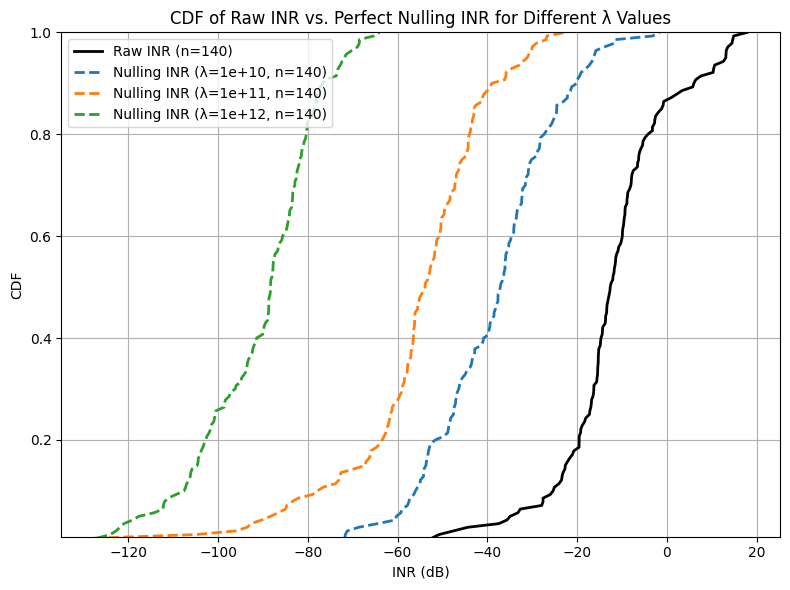

In [30]:
# Create a new figure
plt.figure(figsize=(8, 6))

# ------- Plot raw INR (no nulling) -------
inr_array = np.array(inr_list)
inr_array = inr_array[np.isfinite(inr_array)]
inr_sorted = np.sort(inr_array)
if len(inr_sorted) > 0:
    cdf_inr = np.arange(1, len(inr_sorted) + 1) / len(inr_sorted)
    plt.plot(inr_sorted, cdf_inr, label=f"Raw INR (n={len(inr_sorted)})", linewidth=2, color='black')

# ------- Plot INR Nulling for each lambda -------
for lambda_ in lambda_ranges:
    raw_inr_null_list = inr_nulling_dict[lambda_]
    inr_null_array = np.array(raw_inr_null_list)
    inr_null_array = inr_null_array[np.isfinite(inr_null_array)]
    inr_null_sorted = np.sort(inr_null_array)

    if len(inr_null_sorted) > 0:
        cdf_inr_null = np.arange(1, len(inr_null_sorted) + 1) / len(inr_null_sorted)
        plt.plot(inr_null_sorted, cdf_inr_null,
                 label=f"Nulling INR (λ={lambda_:.0e}, n={len(inr_null_sorted)})",
                 linestyle="--", linewidth=2)

# ------- Make the plot pretty -------
plt.xlabel("INR (dB)")
plt.ylabel("CDF")
plt.title("CDF of Raw INR vs. Perfect Nulling INR for Different λ Values")
plt.grid(True)
plt.legend()
plt.ylim([0.01, 1])
plt.tight_layout()
plt.show()


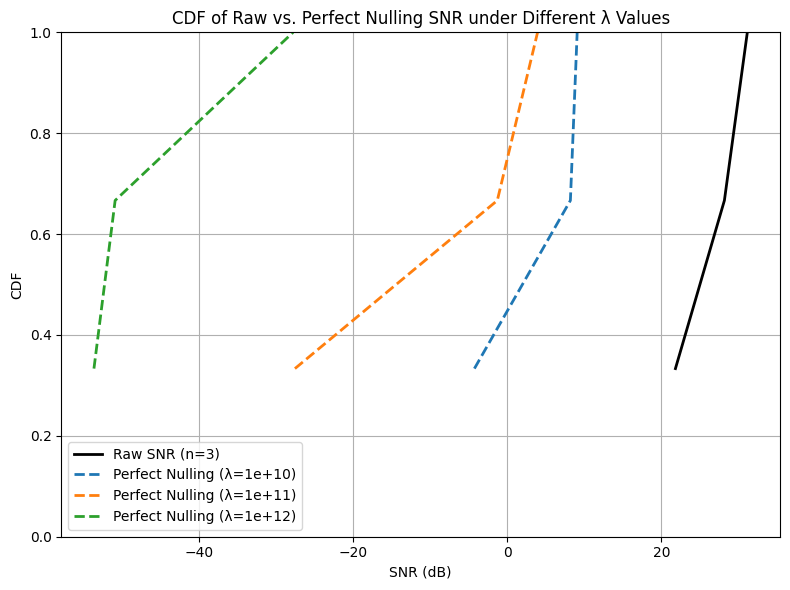

In [31]:
plt.figure(figsize=(8, 6))
# ------- Plot raw SNR (no nulling) -------
snr_array = np.array(snr_list)
snr_array = snr_array[np.isfinite(snr_array)]
snr_sorted = np.sort(snr_array)

if len(snr_sorted) > 0:
    cdf_snr = np.arange(1, len(snr_sorted) + 1) / len(snr_sorted)
    plt.plot(snr_sorted, cdf_snr, label=f"Raw SNR (n={len(snr_sorted)})", linewidth=2, color='black')

# ------- Plot Nulling SNR for each lambda -------
for lambda_ in lambda_ranges:
    # Ideal interference known
    snr_null = np.array(snr_nulling_dict[lambda_])
    snr_null = snr_null[np.isfinite(snr_null)]
    snr_null_sorted = np.sort(snr_null)

    if len(snr_null_sorted) > 0:
        cdf_snr_null = np.arange(1, len(snr_null_sorted) + 1) / len(snr_null_sorted)
        plt.plot(snr_null_sorted, cdf_snr_null,
                 label=f"Perfect Nulling (λ={lambda_:.0e})", linestyle='--', linewidth=2)


# ------- Make the plot nice -------
plt.xlabel("SNR (dB)")
plt.ylabel("CDF")
plt.title("CDF of Raw vs. Perfect Nulling SNR under Different λ Values")
plt.grid(True)
plt.legend()
plt.ylim([0, 1])
plt.tight_layout()
plt.show()


Different Satellite Angle